## MNIST Dataset Classifier

Table of Contents:

1. [Data Collection](#data-collection)
2. [Data Exploration](#eda)
3. [Data Preprocessing](#preprocessing)<br>
    3.1 [Data Augmentation](#augmentation)<br>
    3.2 [Train/Test Split and Scaling](#train-test-scale)

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### 1. Data Collection <a class="anchor" id="data-collection"></a>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

### 2. Data Exploration (EDA) <a class="anchor" id="eda"></a>

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
def display_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis=('off')
    plt.show()

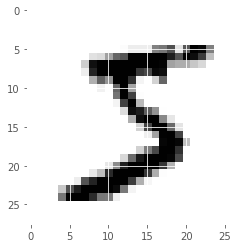

In [7]:
# Look at an example image
some_image = X[0].reshape(28, 28)
display_image(some_image)

### 3. Data Preprocessing <a class="anchor" id="preprocessing"></a>

#### 3.1 Data Augmentation <a class="anchor" id="augmentation"></a>

In [20]:
import scipy.ndimage.interpolation as interp

In [21]:
# Shift an image down and/or right by a specified amount (in pixels)
def shift_image(image, num_px_down=0, num_px_right=0):
    return interp.shift(image, [num_px_down, num_px_right], cval=0)

In [22]:
# Displays a row of images
def display_images(images):
    num_images = len(images)
    f, ax = plt.subplots(1, num_images)
    for i in range(num_images):
        ax[i].imshow(images[i], cmap='binary')
    
    plt.axis=('off')
    plt.show()

In [23]:
# Reshape images in dataset (28 pixels by 28 pixels)
X_reshaped = [image.reshape(28, 28) for image in X]

In [24]:
# Perform data augmentation (shift each image up/right/down/left by 1 pixel each)
directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
X_shifted = []

for i, image in enumerate(X_reshaped):
    X_shifted.append(image)
    for (num_px_down, num_px_right) in directions:
        shifted_image = shift_image(image, num_px_down, num_px_right)
        X_shifted.append(shifted_image)
    if (i+1) % 10000 == 0 and i != 0:
        print(f'Images processed: {i+1}')

Images processed: 10000
Images processed: 20000
Images processed: 30000
Images processed: 40000
Images processed: 50000
Images processed: 60000
Images processed: 70000


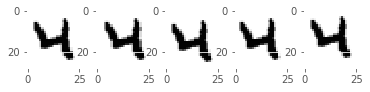

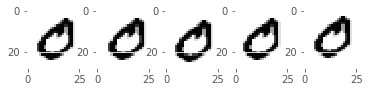

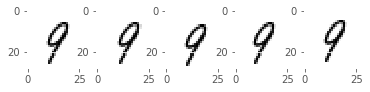

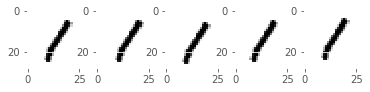

In [25]:
# See result of augmentation
copies = 5
num_items = 4
start = 100

for i in range(start, start + len(X_shifted[:num_items*copies]), copies):
    display_images(X_shifted[i:i+copies])

In [38]:
# Finally flatten all images back to original feature vectors
X_new = np.array([image.flatten() for image in X_shifted])

numpy.ndarray

In [39]:
# Extend labels list
y_new = []
for label in y:
    y_new.extend([label] * copies)
y_new = np.array(y_new)

In [40]:
# Check len's and shapes are as expected
len(X_shifted), X_shifted[0].shape, len(X_new), X_new[0].shape[0], len(y_new)

(350000, (28, 28), 350000, 784, 350000)

#### 3.2 Training and Test Sets and Scaling  <a class="anchor" id="train-test-scale"></a>

In [41]:
# Create training and testing sets (already split, but each image has 5 versions due to augmentation)
# Original dataset: 60k train, 10k test. Augmented dataset: 300k train, 50k test
X_train, X_test, y_train, y_test = X_new[:300000], X_new[300000:], y_new[:300000], y_new[300000:]

In [1]:
from sklearn.preprocessing import StandardScaler

# Scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

NameError: name 'X_train' is not defined

### 4. Model Selection

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [11]:
def plot_roc_curve(fpr, trp, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

In [12]:
# # Fit SVC instance to training data
# ovr_clf = OneVsRestClassifier(SVC())
# start_train = time.time()
# ovr_clf.fit(X_train, y_train)
# print(f'Training time: {round(time.time() - start_train, 2)}s')

In [13]:
# # Get predictions
# ovr_clf.predict([some_digit])
# # len(ovr_clf.estimators_)

In [14]:
import joblib

def save_model(model, filepath):
        joblib.dump(model, filepath)
        
def load_model(filepath):
    return joblib.load(filepath)

In [15]:
# Save best model to disk
# save_model(ovr_clf, filepath='models/svm_ovr_mnist.pkl')

In [16]:
# loaded_model = load_model('models/svm_ovr_mnist.pkl')

In [17]:
# Try KNN model
knn_clf = KNeighborsClassifier()
start_train = time.time()
knn_clf.fit(X_train, y_train)
print(f'Training time: {round(time.time() - start_train, 2)}s')

Training time: 23.21s


### 5. Fine-Tune Selected Model

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# Specify parameter grid
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 15]}
]

# Run grid search on chosen model (KNN)
knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

### 6. Error Analysis